# **1. 모듈 설치 및 호출**

In [1]:
#  유전 알고리즘 모듈 설치
#!pip install geneticalgorithm

In [2]:
# 기본 모듈
import os
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint
import chardet
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

# 시각화 관련
import matplotlib.pyplot as plt
from PIL import Image

# 모델 관련
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor

# GA 
from geneticalgorithm import geneticalgorithm


# 불필요한 경고 표시 생략
import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format

# 파일 로드위한 directory 확인 및 현재 경로로 설정
a = os.getcwd()
os.chdir(a)

# **2. 데이터 로드 및 탐색적 데이터 분석**
---

- 데이터 출처 : 케글 (https://www.kaggle.com/datasnaek/youtube-new)
- 한국 데이터를 사용

In [3]:
filename = 'KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: ascii


- video_id : 유튜브 영상 고유 id
- trending_date : 데이터가 집계된 날짜
- title : 영상 제목
- channel_title : 영상을 올린 채널명
- category_id : 카테고리 아이디 )
- publish_time : 영상을 올린 시간
- tags : 영상에 달린 태그
- views : 조회수(target value)
- likes : 좋아요 수
- dislikes : 싫어요 수
- comment_count : 댓글 수
- thumbnail_link : 썸네일 링크
- comments_disabled : 댓글을 막았는지 여부 (False가 긍정 =  댓글이 있다.)
- ratings_disabled : 평점 여부 (False가 긍정 = rating이 있다.)
- video_error_or_removed : 영상 삭제 여부 (True가 삭제된 것)
- description : 영상에 대한 설명

In [4]:
# 데이터 출처의 KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [5]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                34567 non-null  object
 1   trending_date           34567 non-null  object
 2   title                   34567 non-null  object
 3   channel_title           34567 non-null  object
 4   category_id             34567 non-null  int64 
 5   publish_time            34567 non-null  object
 6   tags                    34567 non-null  object
 7   views                   34567 non-null  int64 
 8   likes                   34567 non-null  int64 
 9   dislikes                34567 non-null  int64 
 10  comment_count           34567 non-null  int64 
 11  thumbnail_link          34567 non-null  object
 12  comments_disabled       34567 non-null  bool  
 13  ratings_disabled        34567 non-null  bool  
 14  video_error_or_removed  34567 non-null  bool  
 15  de

- description에 결측치가 있을 것으로 예상된다.

In [7]:
# 설명이 없는 영상의 수
raw_data['description'].isnull().sum()

3163

In [8]:
# 댓글이 없는 영상의 수
print(f'댓글이 없는 영상의 수 :', raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum(),'개')

댓글이 없는 영상의 수 : 511 개


In [9]:
# 평점이 없는 영상의 수
print(f'평점이 없는 영상의 수 :', raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum(),'개')

평점이 없는 영상의 수 : 1400 개


In [10]:
# 삭제된 영상의 수
print(f'삭제된 영상의 수 :',raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum(),'개')

삭제된 영상의 수 : 41 개


In [11]:
# 각 컬럼별 중복된 데이터의 수 출력
for i in list(raw_data):
    print(f'컬럼명 :',i)
    print(f'중복된 데이터의 수 :\n',raw_data[i].duplicated().value_counts())
    print('\n')

컬럼명 : video_id
중복된 데이터의 수 :
 True     18691
False    15876
Name: video_id, dtype: int64


컬럼명 : trending_date
중복된 데이터의 수 :
 True     34362
False      205
Name: trending_date, dtype: int64


컬럼명 : title
중복된 데이터의 수 :
 True     18214
False    16353
Name: title, dtype: int64


컬럼명 : channel_title
중복된 데이터의 수 :
 True     30524
False     4043
Name: channel_title, dtype: int64


컬럼명 : category_id
중복된 데이터의 수 :
 True     34550
False       17
Name: category_id, dtype: int64


컬럼명 : publish_time
중복된 데이터의 수 :
 True     18705
False    15862
Name: publish_time, dtype: int64


컬럼명 : tags
중복된 데이터의 수 :
 True     23776
False    10791
Name: tags, dtype: int64


컬럼명 : views
중복된 데이터의 수 :
 False    30690
True      3877
Name: views, dtype: int64


컬럼명 : likes
중복된 데이터의 수 :
 True     25093
False     9474
Name: likes, dtype: int64


컬럼명 : dislikes
중복된 데이터의 수 :
 True     32492
False     2075
Name: dislikes, dtype: int64


컬럼명 : comment_count
중복된 데이터의 수 :
 True     29878
False     4689
Name: comment_count, dtype: 

video_id가 중복된 것이 많아 삭제해줄 필요가 있어 보인다.

In [12]:
df = raw_data[raw_data['comments_disabled'] != 1] # True를 삭제(댓글없는 영상)
df = df[df['ratings_disabled'] != 1] # True를 삭제(별점 없는 영상)
df = df[df['video_error_or_removed'] != 1] # True를 삭제(삭제된 영상)
df = df[df['tags'] != '[none]'] # tag 중 none으로 되어있는 데이터 drop (tag 수도 측정 지표로 사용해야 하는데 string이라서 count됨)
print(df.info(), '\n')
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26078 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                26078 non-null  object
 1   trending_date           26078 non-null  object
 2   title                   26078 non-null  object
 3   channel_title           26078 non-null  object
 4   category_id             26078 non-null  int64 
 5   publish_time            26078 non-null  object
 6   tags                    26078 non-null  object
 7   views                   26078 non-null  int64 
 8   likes                   26078 non-null  int64 
 9   dislikes                26078 non-null  int64 
 10  comment_count           26078 non-null  int64 
 11  thumbnail_link          26078 non-null  object
 12  comments_disabled       26078 non-null  bool  
 13  ratings_disabled        26078 non-null  bool  
 14  video_error_or_removed  26078 non-null  bool  
 15  de

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [13]:
print('Before dropna:', len(df))
df = df.dropna() # null값 삭제

print('After  dropna:', len(df))
df = df.reset_index(drop=True)

# 약 1300여개의 데이터가 삭제 됨

Before dropna: 26078
After  dropna: 24768


# 3. 피쳐 엔지니어링

## 썸네일(thumnail_link) 데이터 가공

- **한번 실행했었다면 재실행 하지 말고 및의 csv파일 다운받아서 진행할 것(용량 너무 커서 오래걸림)** 
<br><br>
- Yutube에서 썸네일은 매우 중요한 요소중 하나임이 일반적으로 알려져 있다. 
- 하지만 현재 df에서는 썸네일 링크밖에 없어서 썸네일에 대한 요소를 활용하기가 어렵다.
- 이를 RGB의 intensity value를 추출해서 각 영상의 썸네일 데이터를 구분할 수 있도록 할 것.

In [14]:
# 파일이 없다면 전처리 시작
if not os.path.exists('rgb_df.csv'):
    r_avg = []
    g_avg = []
    b_avg = []

    for i in tqdm_notebook(range(len(df))):
        url = df['thumbnail_link'][i] 
        res = requests.get(url) # 썸네일 링크 가져오기
        request_get_img = Image.open(BytesIO(res.content)) # res.content로 링크의 내용 불러오기
        red, green, blue = request_get_img.split() # 이미지의 RGB 실제 array값 받아오기

        # array값의 평균을 numpy로 계산
        r_avg.append(int(np.average(red))) 
        g_avg.append(int(np.average(green)))
        b_avg.append(int(np.average(blue)))

    # 생성한 데이터를 컬럼으로 생성하여 적용
    df['r_avg'] = r_avg
    df['g_avg'] = g_avg
    df['b_avg'] = b_avg
# file이 존재하면 전처리 생략하고 기존 파일 load
else:
    df = pd.read_csv('rgb_df.csv')

- RGB의 평균외에 표준편차, histogram의 bin값 등을 추출할수 도 있지만, 데이터의 차원수를 과도하게 늘리지는 것을 피하기 위해 일단 평균값만 추출 

In [15]:
# 파일이 없다면 전처리 시작
if not os.path.exists('rgb_df.csv'):
    df.to_csv('rgb_df.csv', encoding='utf8',index=False) # 중간저장1
else :
    df = df.copy()
    

# 결과 확인
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


- RGB값이 모두 193으로 동일하게 나오는 데이터가 있다.
- 확인해보니 썸네일 이미지가 없는 데이터이다. (아래 그림 참조)
- 이러한 데이터가 몇개인지 확인해볼 필요가 있다.
![image](https://user-images.githubusercontent.com/74717033/139681191-ad0a98a8-d091-4578-9085-5977680e52dc.png)

In [16]:
# R과 G의 값이 동일한 데이터와 G와 B의 값이 동일한(=RGB값이 모두 동일한) 데이터를 check_table로 지정 
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('썸네일이 없는 데이터 삭제 전:', len(df))
df_rgb = df[df['r_avg'] != 193] # RGB값이 193아닌 데이터(썸네일이 있는 데이터만 추출)
print('썸네일이 없는 데이터 삭제 후:', len(df_rgb))

# 중간 저장
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False) 

len_check_table: 9865
썸네일이 없는 데이터 삭제 전: 24768
썸네일이 없는 데이터 삭제 후: 15019


## video_id 중복인 데이터 전처리
---

-  "#NAME?" 인 데이터들이 중복으로 잡히는 것 같다.
-  실제 title을 보면 중복된 데이터인 경우가 많다.
-  동일 동영상도 측정 기간에 따라 인기 동영상으로 다시 선정 될 수 있다.
-  view수, like, dislike등은 다를 수 있지만, 모델에서 overestimation(과대평가) 될 우려가 있으므로 drop해주는 것이 좋다.

In [17]:
# 중간 저장데이터 불러오기
df_rgb = pd.read_csv('df_color_encode.csv')

# video_id가 중복인 데이터 확인
print(f'video_id가 중복인 데이터의 수 \n',df['video_id'].duplicated().value_counts(), '개')
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

video_id가 중복인 데이터의 수 
 True     13672
False    11096
Name: video_id, dtype: int64 개


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
9282,#NAME?,18.01.04,사실상 패션 대결 - 온라인 쇼핑 vs 시장 쇼핑 [대신리뷰],왓더펀 What The Fun,24,2018-03-30T09:00:00.000Z,"왓더펀|""whatthefun""|""what the fun""|""wtf""|""대신리뷰""|""...",98391,1591,25,293,https://i.ytimg.com/vi/-wwalatJW4E/default.jpg,False,False,False,우리가 입은게 뭐 어때서..\n채널 구독하기\nhttps://www.youtube....,92,81,69
5238,#NAME?,18.30.01,앜ㅋㅋ 생방 테러좀 그만해!!!! 헛 후원요? ㄱㅅ,테드TV,20,2018-01-29T09:05:33.000Z,"테드|""테드tv""|""ted""|""tedtv""|""도티""|""모바일""|""모바일게임""|""mo...",194231,2888,124,1877,https://i.ytimg.com/vi/-xSxTOCfX4Y/default.jpg,False,False,False,테러냐 후원이냐 그것이 문제로다\n\n✅테드tv 무료 구독 : https://you...,103,94,80
14563,#NAME?,18.10.06,[2018 KBO 정규시즌] 이렇게 멋진 세리머니 보신 적 있으십니까 두산 베어스의...,BearSpotv베어스포티비,17,2018-06-10T11:31:47.000Z,"spotv|""스포티비""|""bearspotv""|""베어스포티비""|""베어스TV""|""두산""...",28169,914,7,185,https://i.ytimg.com/vi/-ifYtIQ9KIc/default.jpg,False,False,False,이렇게 멋진 세리머니 보신 적 있으십니까2018 올스타 2루수 부문 1위! 두산 베...,97,97,83
2992,#NAME?,17.26.12,171225 가요대전 위 아 더 퓨처 워너원 강다니엘 포커스 4K 직캠 / We A...,Peach Crush,22,2017-12-25T15:36:52.000Z,"워너원|""강다니엘""|""가요대전""|""위아더퓨처""|""We Are The Future""|...",52640,3731,12,188,https://i.ytimg.com/vi/-sNZpyBwx-Q/default.jpg,False,False,False,출처 명시 및 로고 유지 하에 짤 생성과 퍼가기를 통한 단순한 이동이 가능합니다. ...,96,96,108
13134,#NAME?,18.25.05,[이춘근의 국제정치 40회] 김정은의 딜레마,이춘근TV,25,2018-05-23T21:00:00.000Z,"이춘근TV|""이춘근""|""이춘근의국제정치""|""국제정치""|""한반도문제""|""국제문제""|""...",84039,4262,76,313,https://i.ytimg.com/vi/-FdFHEogWsU/default.jpg,False,False,False,♥ 후원안내 ♥ 많은 후원문의 감사합니다 ※국내 후원 110-480-334678 신...,77,69,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7728,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7537,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7608,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11408,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [18]:
# video_id가 '#NAME?' 인 데이터 목록 추출
print(f'video_id가 #NAME?인 데이터의 개수는',len(df_rgb[df_rgb['video_id']=='#NAME?']), '개 이다.\n')

df_rgb[df_rgb['video_id']=='#NAME?']

video_id가 #NAME?인 데이터의 개수는 211 개 이다.



,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
34,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
117,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
157,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
158,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
206,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14791,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14852,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14930,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14965,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [19]:
print('video_id가 중복인 데이터 삭제 전:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('video_id가 중복인 데이터 삭제 후:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

video_id가 중복인 데이터 삭제 전: 15019
video_id가 중복인 데이터 삭제 후: 6578


In [20]:
# 결과 확인
df_rgb2.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
2,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
3,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61
4,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,357,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117,103,100


## publish_time & trending_date 컬럼 전처리
---

- 각각의 데이터로는 큰 의미가 없을 것 같다. 
- 하지만 영상을 올린날과 인기 영상으로 집계된 날의 차이를 보면 유의미한 데이터가 될 수 있을 것 같다. (= 경과 일수))

### publish_time 전처리

- 데이터에 'T'와 'Z'라는 불필요한 데이터가 들어가 있다.
- 상세한 시간 데이터는 불필요한 데이터일 듯 하다.  
- split()을 이용해 'T'를 기준으로 나눠준다.

In [21]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0]) # str타입으로 변경
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]') # datetime 타입으로 변경
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6573   2018-06-11
6574   2018-06-13
6575   2018-06-13
6576   2018-06-13
6577   2018-06-13
Name: publish_date, Length: 6578, dtype: datetime64[ns]

### trending_date 전처리

In [22]:
# 연/월/일 형식으로 지정
# 단정할 순 없지만 publish_tiem이 17년으로 시작하는 것으로 보아 17은 연도일 가능성이 크다.

df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6573   2018-06-14
6574   2018-06-14
6575   2018-06-14
6576   2018-06-14
6577   2018-06-14
Name: trending_date, Length: 6578, dtype: datetime64[ns]

### 경과 일수 데이터(=elapsed_day) 생성

- 영상을 올린날에 인기동영상 데이터로 수집된 경우 단순 연산을 하면 값이 0이 될 수 밖에 없다.
- 따라서 1을 더해서 데이터가 유의미한 값을 가질 수 있도록 처리한다.

In [23]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days # datetime64 형태에서 원하는 형태인 day형태로 변환
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6573    4
6574    2
6575    2
6576    2
6577    2
Name: elapsed_day, Length: 6578, dtype: int64

## 영상 관심도(total_number_of_sign)

- 좋아요 수 + 싫어요 수

In [24]:
# 영상 관심도 (total_number_of_sign)
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

## 영상에 달린 tag의 수

- 텍스트 데이터에서 가장 단순하게 의미를 추출할때 사용 가능한 방법
- 그 외에 tag에 사용된 단어 의미간의 군집도, 벡터 or 코사인 거리 등을 추출해보는 것도 좋은 방법
- 관련 전처리가 많이 늘어 나기 때문에 추후 sub-project로 진행 할 예정
---

- tag 예시 : 라푸마|"윤종신"|"좋니"|"좋아"|"샬레"|"민서"
- '|' 로 각 tag가 구분되어 string으로 되어 있다.
- 이를 | 기준으로 split한뒤에 몇개의 tag가 사용되었는지 len으로 count한다.
- 단, tag가 없는 경우를 대비해 none이 아니라면 count하고, none이면 0으로 바꿔준다.

In [25]:
df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

## 영상에 대한 긍정평가 비율 (positive_ratio)

- 기존 idea = like 수 / dislike 수
- 문제 발생 : dislike 수가 0인 경우가 발생 -> 연산 결과가 inf로 나옴.(모델이 데이터 해석을 할수 없다.)
- 즉, inf를 다른 값으로 replace 해줘야 한다.
- 보통은 df내에 있는 다른 값보다 '충분히 큰값' 으로 대체를 해준다. (max값 많이 사용)
- 하지만 max값으로 대체할 경우 추후 모델링을 위해 scailing을 했을때, 다른 값들이 한곳으로 뭉쳐서 데이터간 대소 구분이 불가해진다.(데이터 왜곡)
- 해결책 : "like 수 / dislike 수" 결과 중 inf 제외 가장 큰 값을 찾아서 배수를 곱해준다.
- **왜 1.5를 곱할까?**
    - 분석가의 임의 설정 값
    - max값을 10배로 한다면 기존의 다른 값들이 1/10 이하로 뭉쳐서 왜곡될 우려가 있다. (적당히 크게 만들어 줘야 함.)

In [26]:
df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']

# 현재 df_rgb2['positive_ratio'] 에서 max값은 'inf' 이므로 여기에 1.5를 곱해봐야 무의미
# inf를 0으로 replace한 결과를 추출
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max() 

# inf값을 사전에 구한 positive_ratio_max (inf를 제외한 max값에 1.5곱한 것)
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5) # 가장 큰값 * 1.5한 값으로 inf를 대체

## 영상의 하루당 관심도 (sign_per_day)
- 영상 전체의 관심도(total_number_of_sign) / 경과일 (elapsed_day) 
- 즉, 영상에 대한 관심이 매일 얼마나 되었는가

In [27]:
df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

## 하루에 영상에 대해 내려지는 긍정평가의 비율 (positive_ratio)

- 영상에 대한 전체 긍정평가 비율 / 경과일

In [28]:
df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

## 영상에 하루에 달리는 댓글의 수 (comment_per_day)

- 전체 댓글 수 / 경과일

In [29]:
df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

## 영상에 대한 총 관심도 비율(total_sign_comment_ratio)

- 전체 관심도 / 댓글 수
- 단, comment_count가 0인 경우가 있다. (positive_ratio와 동일한 경우)
- 동일 방식으로 처리

In [30]:
# 총 관심 비율 계산
df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']

# inf값을 제외한 max값 구하기
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max() # string개수 count


df_rgb2['total_sign_comment_ratio'] = \
df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

## 영상의 description길이 (description_length)

- 영상 description에 얼마나 자세한 설명을 제공하는가
- tag 개수 count할때와 비슷

In [31]:
df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

## 영상 제목의 길이(title_length)

In [32]:
df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [33]:
# 결과 확인
df_rgb2.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,...,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length
0,RxGQe4EeEpA,2017-11-14,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,...,2,1462,6,35.55,731.00,17.77,136.00,5.38,152,18
1,9V8bnWUmE9U,2017-11-14,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,...,4,5278,6,30.80,1319.50,7.70,114.75,11.50,15,26
2,0_8py-t5R80,2017-11-14,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,...,3,2266,9,12.10,755.33,4.03,406.33,1.86,19,26
3,bk55RbxiQdI,2017-11-14,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,...,2,1203,7,10.04,601.50,5.02,225.00,2.67,389,23
4,AmP0ryzDmbY,2017-11-14,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,...,3,856,6,1.75,285.33,0.58,119.00,2.40,289,48


## channel_title 컬럼 전처리

- categorical 데이터를 mean encoding을 통해 숫자 데이터로 변형
    - channel_title_mean_enc : 채널별 평균 view 라는 새로운 컬럼 생성
- 단순 one hot encoding을 해야 할까? -> value_counts()로 확인

In [34]:
df_rgb2['channel_title'].value_counts()

TV Derana                103
JTBC News                 90
황장수의 뉴스브리핑o               85
tbs 시민의 방송                83
o 황장수의 뉴스브리핑              76
                        ... 
Disney Movie Trailers      1
YEA! ENFERMO               1
딩고 스튜디오                    1
eatwithmejin               1
ChildishGambinoVEVO        1
Name: channel_title, Length: 1485, dtype: int64

너무 값이 많아서 one hot encoding을 할 경우 차원의 저주에 빠질 가능성이 매우 크다.

- **mean encoding을 활용**
    - channel_title 데이터의 차원수를 늘리지 않으면서 의미는 도출 가능
    - mean_encode_channel 는 추후 channel_title_mean_enc이 어떤 의미지인지 역유추 할때 사용될 수 있으므로 keep

In [35]:
# channel_title의 view수 평균 값 추출
# view수 = y 값 (target value)
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print(mean_encode_channel) 

channel_title
!t Live                  64896.67
& 홍대 쏭카페창현 거리노래방        150317.50
(MUTUBE)와꾸대장봉준           72740.00
* eundaromi             129207.50
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道   799644.00
                           ...   
흔한남매                    104829.00
히스토리                    230128.00
히죽HIZUK                  77737.00
히히튜브                     29389.00
힙합버스                     99130.50
Name: views, Length: 1485, dtype: float64


In [36]:
# channel_title_mean_enc 컬럼에 channel_title의 평균 view 값을 mapping
df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

0      125208.00
1      421409.00
2      258691.29
3      184936.65
4      178386.07
          ...   
6573    15136.50
6574    41945.44
6575    31731.50
6576    23404.00
6577   140520.19
Name: channel_title_mean_enc, Length: 6578, dtype: float64

## category_id 컬럼 전처리

- channel_title과 같은 방식으로 처리

In [37]:
df_rgb2['category_id'].value_counts()

24    1858
25    1238
22     872
23     509
10     471
20     448
1      352
15     193
17     177
26     171
27      88
43      69
29      67
2       24
28      23
19      18
Name: category_id, dtype: int64

In [38]:
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1     396628.87
2      81669.04
10   1566611.81
15    119128.68
17    735331.22
19    202138.72
20    198043.89
22    148025.13
23    277000.79
24    408503.16
25    132860.43
26    362402.16
27     98294.27
28   1678646.17
29     23327.10
43     78841.58
Name: views, dtype: float64


0      148025.13
1      148025.13
2      132860.43
3      132860.43
4      132860.43
          ...   
6573   735331.22
6574   148025.13
6575   408503.16
6576   396628.87
6577   132860.43
Name: category_id_mean_enc, Length: 6578, dtype: float64

## 전처리 결과 scatter plot으로 확인 (views와 각 컬럼의 관계)

- 숫자형 데이터와의 관계만을 확인 -> description 사용

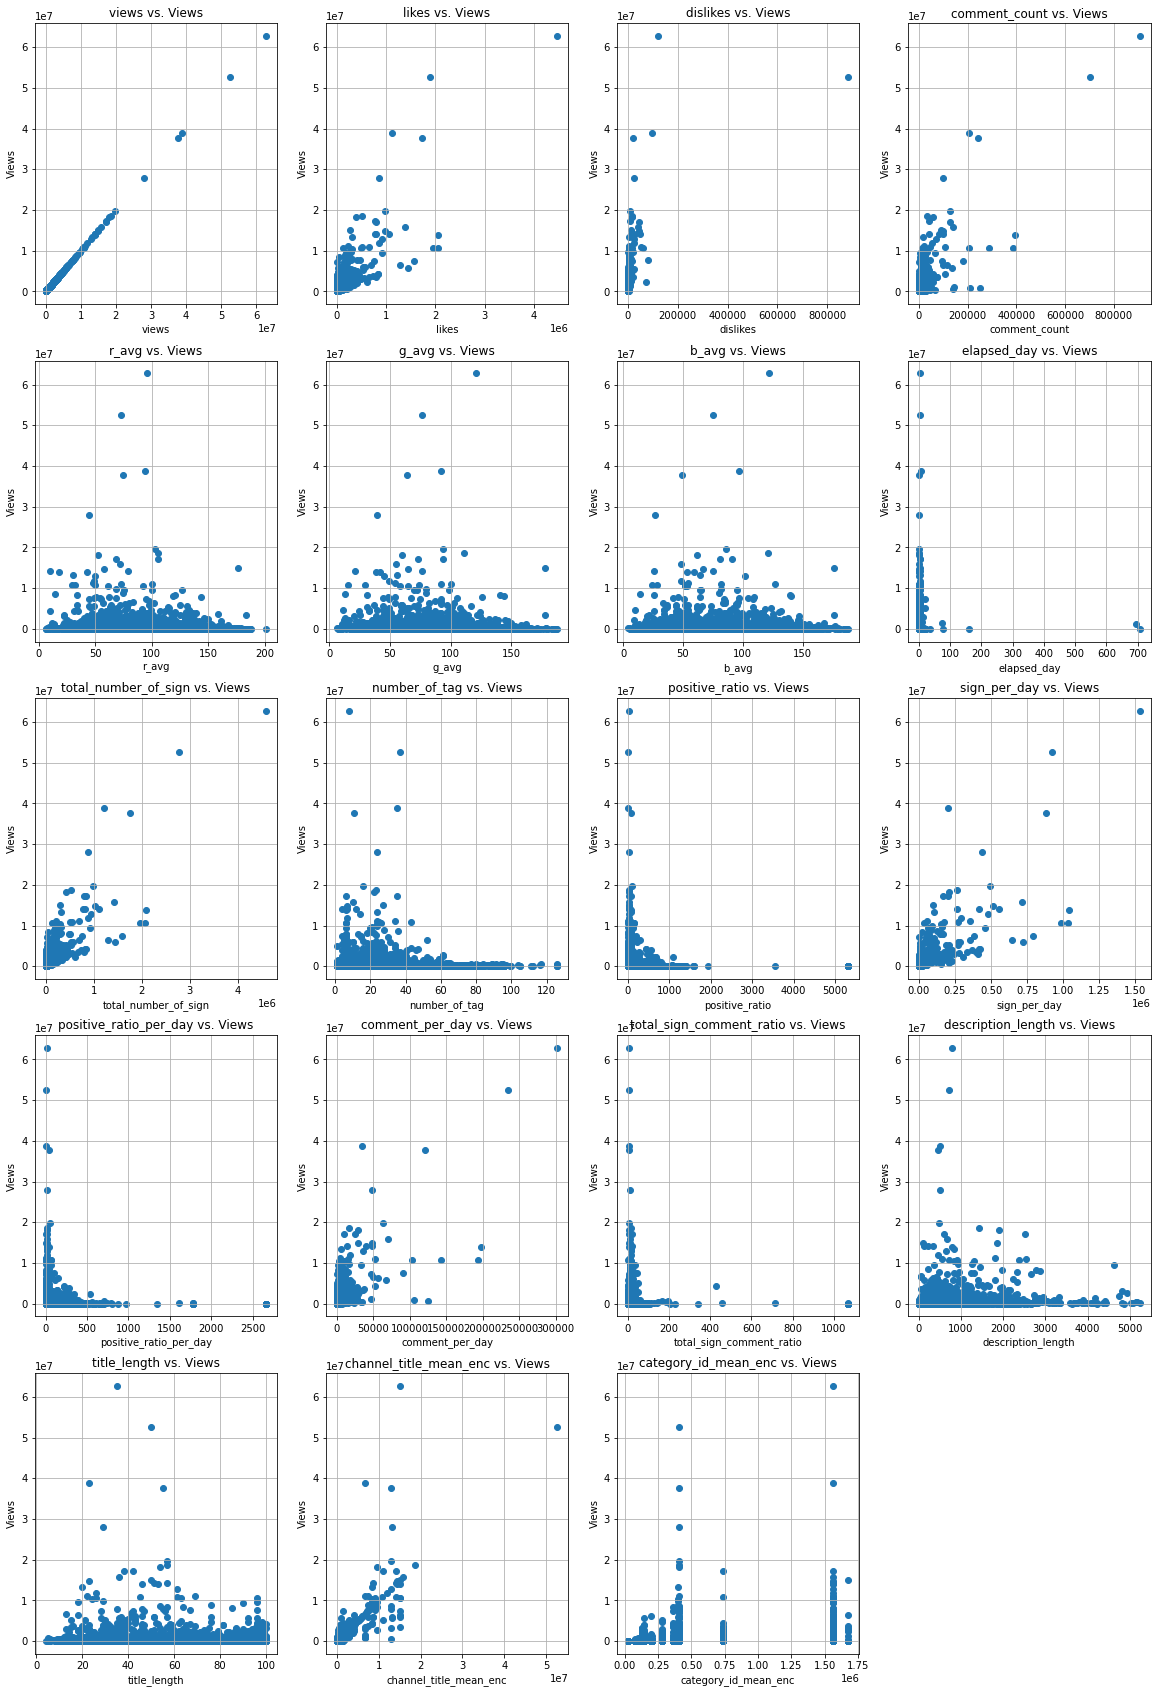

In [39]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)): # 컬럼별로 describe 데이터 추출
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

- likes vs. Views : 어느정도 연관성이 있을 것으로 예상된다.
- dislikes vs. Views : outlier값때문에 소수의 값이 몰린 것일 수도 있어 뚜렷한 연관성이 보이지 않는다. 약간의 연관성은 있을 수 있음
- comment_count vs. Views : 연관성은 있는듯 하지만 like에 비하면 약해 보인다.
- r_avg vs. Views : 큰 연관은 없어 보인다.
- g_avg vs. Views : 큰 연관은 없어 보인다.
- b_avg vs. Views : 큰 연관은 없어 보인다.
- elapsed_day vs. Views : outlier 영향으로 값이 한쪽에 몰린듯 하다. 추가 전처리 후 살펴볼 필요 있음.
- total_number_of_sign vs. Views : 어느정도의 연관성이 있어 보인다.
- number_of_tag vs. Views : 큰 연관성은 없는 듯 하다.
- positive_ratio vs. Views : 어느정도 연관이 있을 듯 하다. (분수함수 꼴)
- sign_per_day vs. Views : 어느정도의 연관성이 있어 보인다. 
- positive_ratio_per_day vs. Views : positive_ratio와 비슷
- comment_per_day vs. Views : 어느정도의 연관성이 있어보이지만 뚜렷하지 않음
- total_sign_comment_ratio vs. Views : 어느정도 연관이 있을 듯 하다. (분수함수 꼴)
- description_length vs. Views : 큰 연관성은 없어 보인다.
- title_length vs. Views : 큰 연관성은 없어 보인다.
- channel_title_mean_enc vs. Views : 어느정도의 상관성이 있어 보인다. 
- category_id_mean_enc vs. Views : 큰 연관성은 없어 보인다.

#### outlier 영향이 있어 보이던 feature을 다시 살펴 보기

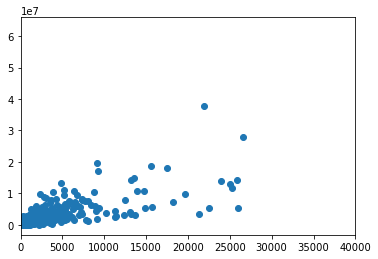

In [40]:
# dislike
plt.xlim(0, 40000)
plt.scatter(df_rgb2['dislikes'], df_rgb2['views'])

# 이상치를 제외하고 봐도 views와 의 인과관게가 크게 있어 보이지는 않는다.

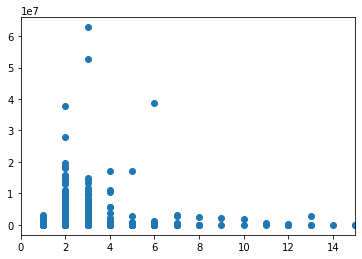

In [41]:
# elapsed_day
plt.xlim(0,15)
plt.scatter(df_rgb2['elapsed_day'], df_rgb2['views'])

# 이상치를 제외하고 봐도 views와 의 인과관게는 크게 없어 보인다.
# 현 단계에서 2~4일의 views가 높다고 해서 "인기 영상이 되려면 업로드 후 4일 내에 조회수가 많이 나와야 한다." 라는 부적절 하다.
# 아직은 그 관계를 단정 지을 수있는 관계성이 보이지 않기 때문

In [42]:
# 전체 컬럼 확인
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

## 다중공선성 확인 with Hierarchical dendrogram

- Hierarchical dendrogram은 관련이 높은 feature끼리 묶어서 군집화 하는 것을 시각화 한 것.
- 단계가 내려 갈 수록 군집화된 feature들을 구분할 수 있다.

                          likes  dislikes  comment_count  r_avg  g_avg  b_avg  \
likes                      1.00       NaN            NaN    NaN    NaN    NaN   
dislikes                    NaN      1.00            NaN    NaN    NaN    NaN   
comment_count               NaN       NaN           1.00    NaN    NaN    NaN   
r_avg                       NaN       NaN            NaN   1.00    NaN    NaN   
g_avg                       NaN       NaN            NaN    NaN   1.00    NaN   
b_avg                       NaN       NaN            NaN    NaN    NaN   1.00   
elapsed_day                 NaN       NaN            NaN    NaN    NaN    NaN   
number_of_tag               NaN       NaN            NaN    NaN    NaN    NaN   
positive_ratio              NaN       NaN            NaN    NaN    NaN    NaN   
sign_per_day               0.98       NaN            NaN    NaN    NaN    NaN   
positive_ratio_per_day      NaN       NaN            NaN    NaN    NaN    NaN   
comment_per_day             

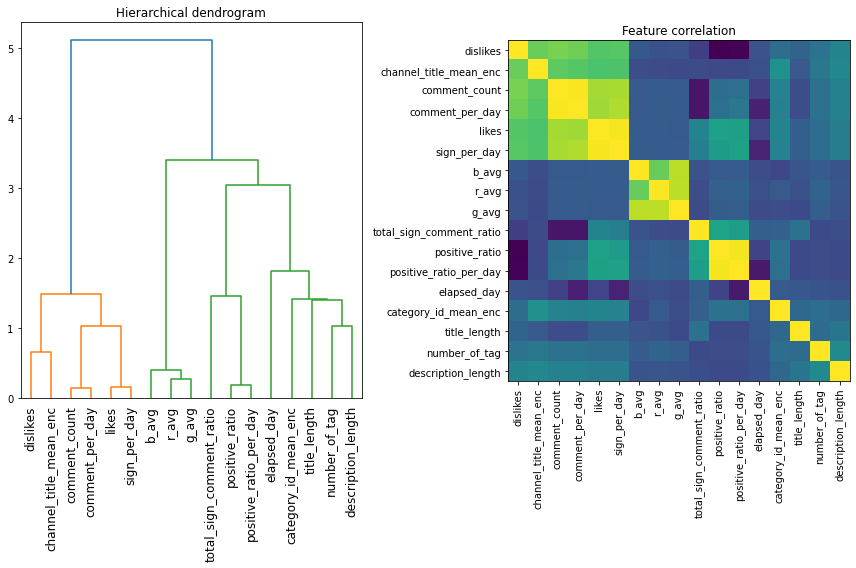

In [43]:
# 분석에 사용할 features만 지정
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features] # x값 지정
cor_table = x_input.corr() # 상관관계 구하기

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

# dendrogram에서 나온 각 feature를 x,y로 받아서 heatmap으로 표현
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

# 상관관계가 0.9 이상인 것만 출력
print(cor_table[cor_table > 0.9])

- likes 와 sign_per_day가 0.98로 강한 상관관계를 보인다.
- positive_ratio 와 positive_ratio_per_day 등 도 높은 상관관계를 보이지만 이는 파생변수이므로 당연.
- 기존 데이터 보다 ~per_day 인 컬럼들이 높은 상관관계를 보인다.
- 다만 위에서 elapsed_day와 views 간의 scatter plot이 큰 영향력이 없었으므로 ~per_day 데이터를 지우고 다시 체크해볼 필요가 있다.

###  ~per_day 컬럼 제외 후 다시 다중공선서 확인

                        likes  dislikes  comment_count  elapsed_day  \
likes                    1.00       NaN            NaN          NaN   
dislikes                  NaN      1.00            NaN          NaN   
comment_count             NaN       NaN           1.00          NaN   
elapsed_day               NaN       NaN            NaN         1.00   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

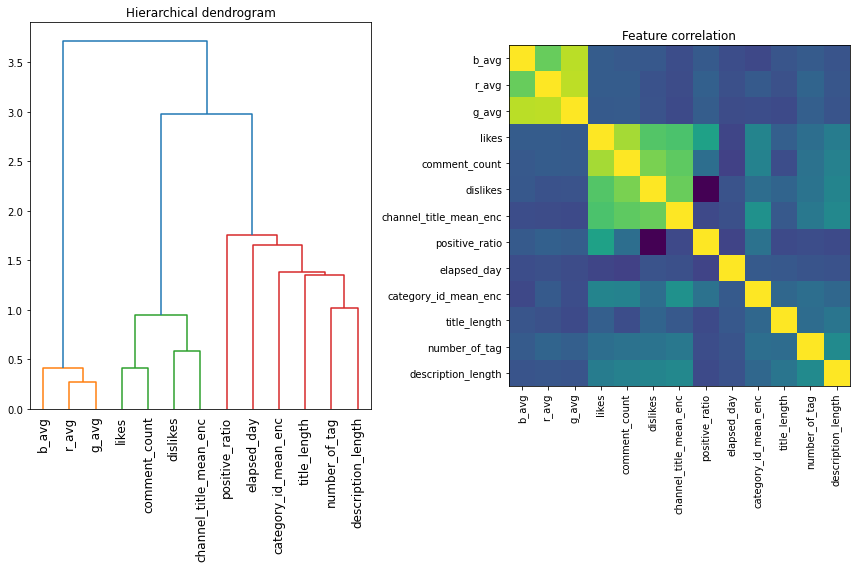

In [44]:
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

# 상관관계가 0.9 이상인 것만 출력
print(cor_table[cor_table > 0.9])

In [45]:
# 상관관계가 -0.9 이상인 것도 확인 (시각화 결과는 동일하므로 생략)
print(cor_table[cor_table < -0.9])

                        likes  dislikes  comment_count  elapsed_day  \
likes                     NaN       NaN            NaN          NaN   
dislikes                  NaN       NaN            NaN          NaN   
comment_count             NaN       NaN            NaN          NaN   
elapsed_day               NaN       NaN            NaN          NaN   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

- 음의 상관관계가 큰 데이터들은 보이지 않는다.

### train / test split

In [46]:
# target value설정
y_output = df_rgb2['views']

# train & test split
x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)